# Uncertainty Quantification in Deep Neural Networks through Statistical Inference on Latent Space

---
### Supplementary material to reproduce results

In this notebook, we reproduce the results presented in the paper 'Uncertainty Quantification in Deep Neural Networks through Statistical Inference on Latent Space' submitted to the conference NeurIPS 2023. To reproduce results, all cells must be activated from top to bottom. 

We import some packages that are required to be installed in the local environment where the notebook is run. Some classes and functions used in the notebook are defined in the modules 'nn' and 'confidence_eval'. 

In [1]:
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
from nn import Classifier, train_classifier
from confidence_eval import get_confidence_inference, get_percentiles_inference, get_confidence_mcdropout, get_confidence_ensemble

In [2]:
# %load_ext autoreload
# %autoreload 2

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

False

First of all, we download the MNIST dataset. Data is then rearranged in a dictionary, classified by their label as a key.

In [5]:
trainset_all = torchvision.datasets.MNIST('./datasets', train=True, download=True, transform=torchvision.transforms.ToTensor())
testset_all = torchvision.datasets.MNIST('./datasets', train=False, download=True, transform=torchvision.transforms.ToTensor())

The dataset is placed in a dictionary where keys are all the unique values of the labels, and each key in the dictionary returns all the instances of the dataset relative to that key.

In [6]:
trainloader = torch.utils.data.DataLoader(trainset_all, batch_size=1)
testloader = torch.utils.data.DataLoader(testset_all, batch_size=1)

x_dict_train = {}
x_dict_test = {}

count = 0
for x,y in trainloader:
    if count==int(len(trainloader)):
        break
    count = count + 1
    if str(y.numpy()[0]) in x_dict_train.keys():
        x_dict_train[str(y.numpy()[0])] = torch.cat([x_dict_train[str(y.numpy()[0])], x])
    else:
        x_dict_train[str(y.numpy()[0])] = x
        
count = 0        
for x,y in testloader:
    if count==int(len(testloader)):
        break
    count = count + 1
    
    if str(y.numpy()[0]) in x_dict_test.keys():
        x_dict_test[str(y.numpy()[0])] = torch.cat([x_dict_test[str(y.numpy()[0])], x])
    else:
        x_dict_test[str(y.numpy()[0])] = x

We select an out-of-distribution value (ood) and build datasets (train and test) that do not contain the ood value - 'trainset' - 'testset', and a dataset that contains only ood values - 'oodset'.

In [7]:
def build_datasets ( ood, x_dict_train, x_dict_test):
    trainset_x = torch.tensor([])
    trainset_y = torch.tensor([])
    testset_x = torch.tensor([])
    testset_y = torch.tensor([])
    oodset = torch.tensor([])

    for key in x_dict_train.keys():
        if key != str(ood):
            trainset_x = torch.cat([trainset_x, x_dict_train[key]])
            trainset_y = torch.cat([trainset_y, float(key)*torch.ones([len(x_dict_train[key])])])
        else:
            oodset_x = torch.cat([oodset, x_dict_train[key]])

    for key in x_dict_train.keys():
        if key != str(ood):
            testset_x = torch.cat([testset_x, x_dict_test[key]])
            testset_y = torch.cat([testset_y, float(key)*torch.ones([len(x_dict_test[key])])])
        else:
            oodset_x = torch.cat([oodset, x_dict_test[key]])

    trainset = torch.utils.data.TensorDataset(trainset_x, trainset_y.long())
    testset = torch.utils.data.TensorDataset(testset_x, testset_y.long())
    oodset = torch.utils.data.TensorDataset(oodset_x, ood*torch.ones([len(oodset_x)]))

    return trainset, testset, oodset

In [8]:
ood = 2
trainset, testset, oodset = build_datasets(ood, x_dict_train, x_dict_test)

Here, we can visualize the composition of the sets built above.

Text(0.5, 1.0, 'ood set')

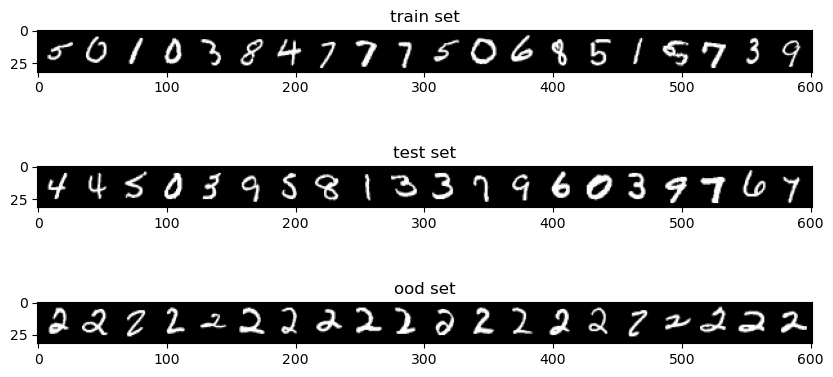

In [9]:
nrow = 20
fig, axs = plt.subplots(3,1, figsize=(10,5))

loader = torch.utils.data.DataLoader(trainset, batch_size=nrow, shuffle=True)
x,y = next(iter(loader))
x_im = torchvision.utils.make_grid(x, nrow=nrow)
axs[0].imshow(np.transpose(x_im.numpy(), (1, 2, 0)))
axs[0].set_title('train set')

loader = torch.utils.data.DataLoader(testset, batch_size=nrow, shuffle=True)
x,y = next(iter(loader))
x_im = torchvision.utils.make_grid(x, nrow=nrow)
axs[1].imshow(np.transpose(x_im.numpy(), (1, 2, 0)))
axs[1].set_title('test set')

loader = torch.utils.data.DataLoader(oodset, batch_size=nrow, shuffle=True)
x,y = next(iter(loader))
x_im = torchvision.utils.make_grid(x, nrow=nrow)
axs[2].imshow(np.transpose(x_im.numpy(), (1, 2, 0)))
axs[2].set_title('ood set')

We can see above that the train set and test set do not contain any ood values, while the ood set contains only ood values.

Next, we compute uncertainties on the prediction of a neural network to predict the label of an input image. We use a dataset where a specific out-of-distribution value is removed. Then we test uncertainties on a test set and on a ood set that contains only out-of-distribution values.
Uncertainties are computed using the three different methods desctibed in the paper i.e. the inference method, the mc-dropout method and the ensemble method.

Let's train some neural networs. Several neural networks are required to be trained because the ensemble method needs different independently trained model to quantify uncertainties.

In [10]:
# out-of-distribution value excluded from the training set
ood = 0

# network architectures - here two layers with 1024 nodes each
layers_nodes = [1024,1024]

# early stopping parameter
accuracy_target = 0.96

# percentiles used by the inference methods
q = (0.1,50)

# number of models used by the mc-dropout method
n_models_mcdropout = 100

# number of models used by the ensemble method - thus number of models to be trained
n_models_ensemble = 10

# dropout ratio used during training and during evaluation in the mc-dropout method
p=0.5

trainset, testset, oodset = build_datasets(ood, x_dict_train, x_dict_test)

classifiers = []

for n in range (n_models_ensemble):
    
    classifier = Classifier(layers_nodes=layers_nodes, p=p).to(device)
    trained = train_classifier(device, classifier, trainset, accuracy_target=accuracy_target)
    while (trained == False):
        classifier = Classifier(layers_nodes=layers_nodes, p=p).to(device)
        trained = train_classifier(device, classifier, trainset, accuracy_target=accuracy_target)
    classifiers.append(classifier)

In [11]:
loader_test = torch.utils.data.DataLoader(testset, batch_size=len(testset))
x_test,y_test = next(iter(loader_test))
y_test = y_test.numpy()
loader_ood = torch.utils.data.DataLoader(oodset, batch_size=len(oodset))
x_ood,_ = next(iter(loader_ood))

The inference and mc-dropout methods require only one model. We use the same model for both methods.

In [12]:
classifier = classifiers[0]

### Inference method

In [29]:
# 'get_percentiles_inference' takes the model trained, the percentiles, 
#  and the training set as input, and it returns all the parameters required to compute uncertainties.  
percentiles, mean, cov, scale_mean, scale_std = get_percentiles_inference(classifier, x_dict_train, ood, q)

# 'get_confidence_inference' gives the model prediction for an input and the uncertainty.
prediction_test_inference, confidence_test_inference = get_confidence_inference(x_test, classifier, percentiles, mean, cov, scale_mean, scale_std)  

# we split between classified and misclassified data to assess the capability of the network to detect wrong predictions.
classified_inference = y_test==prediction_test_inference
misclassified_inference = y_test!=prediction_test_inference
prediction_ood_inference, confidence_ood_inference = get_confidence_inference(x_ood, classifier, percentiles, mean, cov, scale_mean, scale_std)         

After selecting an acceptance threhsolds that determines which predictions are accepted or rejected, we can print the true positives (TP) rate of well classified samples, the true negatives (TN) rate of correctly rejected misclassified samples, the true negatives (TN) rate of correctly rejected out-of-distribution samples.

In [14]:
acceptance_inference = 0.5

print('True positive classified: ', np.mean(confidence_test_inference[classified_inference]>acceptance_inference))
print('True negative misclassified: ', np.mean(confidence_test_inference[misclassified_inference]<acceptance_inference))
print('True negative ood: ', np.mean(confidence_ood_inference<acceptance_inference))

True positive classified:  0.8803596127247579
True negative misclassified:  0.8168604651162791
True negative ood:  0.9857142857142858


Below we see the histograms of the confidence quantified on the samples of the 3 different datasets. We can clearly see that the large majority of out-of-distribution and misclassified samples have low confidence, whereas well classified samples have high confidence.

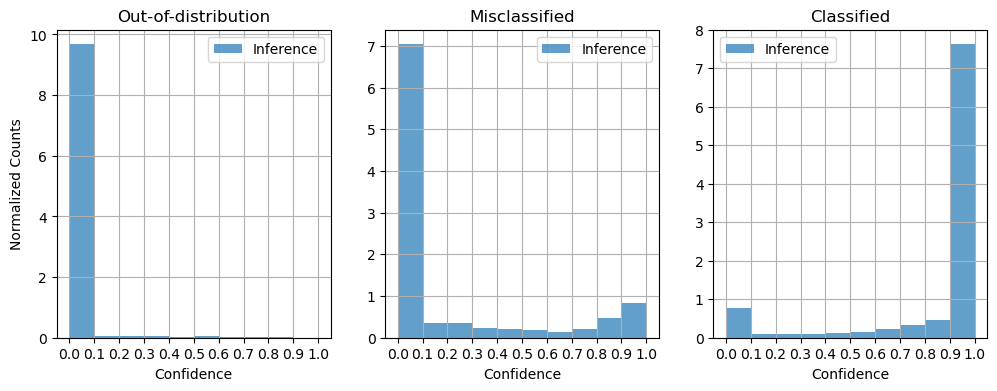

In [15]:
fig, axs = plt.subplots(1,3, figsize=(12,4))
bins = np.linspace(0, 1, num=11)


axs[0].hist(confidence_ood_inference, bins=bins, width=0.1, alpha=0.7, density=True)
axs[0].set_xlabel('Confidence')
axs[0].set_ylabel('Normalized Counts')
axs[0].set_title('Out-of-distribution')
axs[0].set_xticks(bins)
axs[0].grid(True)
axs[0].legend(['Inference'])

axs[1].hist(confidence_test_inference[misclassified_inference], bins=bins, width=0.1, alpha=0.7, density=True)
axs[1].set_xlabel('Confidence')
axs[1].set_title('Misclassified')
axs[1].set_xticks(bins)
axs[1].grid(True)
axs[1].legend(['Inference'])

axs[2].hist(confidence_test_inference[classified_inference], bins=bins, width=0.1, alpha=0.7, density=True)
axs[2].set_xlabel('Confidence')
axs[2].set_title('Classified')
axs[2].set_xticks(bins)
axs[2].grid(True)
axs[2].legend(['Inference'])


Below we repeat the same analysis as above for the MC-dropout and ensemble methods

### MC-dropout method

In [16]:
prediction_test_mcdropout, confidence_test_mcdropout = get_confidence_mcdropout(x_test, classifier, n_models_mcdropout)
classified_mcdropout = y_test==prediction_test_mcdropout
misclassified_mcdropout = y_test!=prediction_test_mcdropout
prediction_ood_mcdropout, confidence_ood_mcdropout = get_confidence_mcdropout(x_ood, classifier, n_models_mcdropout)

In [17]:
acceptance_mcdropout = 0.99

print('True positive classified: ', np.mean(confidence_test_mcdropout[classified_mcdropout]>acceptance_mcdropout))
print('True negative misclassified: ', np.mean(confidence_test_mcdropout[misclassified_mcdropout]<acceptance_mcdropout))
print('True negative ood: ', np.mean(confidence_ood_mcdropout<acceptance_mcdropout))

True positive classified:  0.9659613615455381
True negative misclassified:  0.5771604938271605
True negative ood:  0.49795918367346936


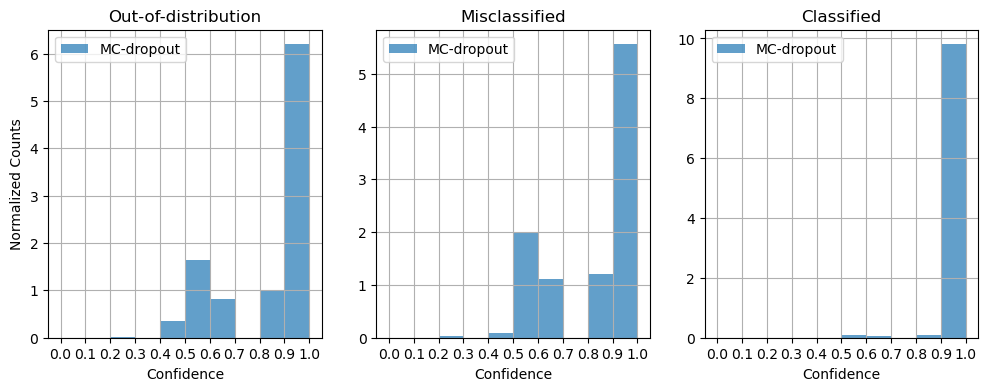

In [18]:
fig, axs = plt.subplots(1,3, figsize=(12,4))
bins = np.linspace(0, 1, num=11)

axs[0].hist(confidence_ood_mcdropout, bins=bins, alpha=0.7, density=True)
axs[0].set_xlabel('Confidence')
axs[0].set_ylabel('Normalized Counts')
axs[0].set_title('Out-of-distribution')
axs[0].set_xticks(bins)
axs[0].grid(True)
axs[0].legend(['MC-dropout'])

axs[1].hist(confidence_test_mcdropout[misclassified_mcdropout],bins=bins, width=0.1, alpha=0.7, density=True)
axs[1].set_xlabel('Confidence')
axs[1].set_title('Misclassified')
axs[1].set_xticks(bins)
axs[1].grid(True)
axs[1].legend(['MC-dropout'])

axs[2].hist(confidence_test_mcdropout[classified_mcdropout],bins=bins, width=0.1, alpha=0.7, density=True)
axs[2].set_xlabel('Confidence')
axs[2].set_title('Classified')
axs[2].set_xticks(bins)
axs[2].grid(True)
axs[2].legend(['MC-dropout'])

### Ensemble method

In [19]:
prediction_test_ensemble, confidence_test_ensemble = get_confidence_ensemble(x_test, classifiers)
classified_ensemble = y_test==prediction_test_ensemble
misclassified_ensemble = y_test!=prediction_test_ensemble
prediction_ood_ensemble, confidence_ood_ensemble = get_confidence_ensemble(x_ood, classifiers)

In [20]:
acceptance_ensemble = 0.99

print('True positive classified: ', np.mean(confidence_test_ensemble[classified_ensemble]>acceptance_ensemble))
print('True negative misclassified: ', np.mean(confidence_test_ensemble[misclassified_ensemble]<acceptance_ensemble))
print('True negative ood: ', np.mean(confidence_ood_ensemble<acceptance_ensemble))

True positive classified:  0.9819290976058932
True negative misclassified:  0.45481927710843373
True negative ood:  0.29489795918367345


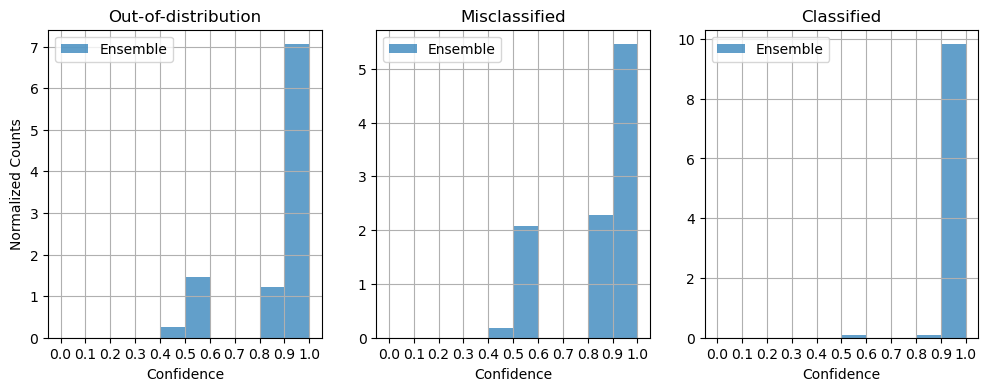

In [21]:
fig, axs = plt.subplots(1,3, figsize=(12,4))
bins = np.linspace(0, 1, num=11)

axs[0].hist(confidence_ood_ensemble, bins=bins, alpha=0.7, density=True)
axs[0].set_xlabel('Confidence')
axs[0].set_ylabel('Normalized Counts')
axs[0].set_title('Out-of-distribution')
axs[0].set_xticks(bins)
axs[0].grid(True)
axs[0].legend(['Ensemble'])

axs[1].hist(confidence_test_ensemble[misclassified_ensemble],bins=bins, width=0.1, alpha=0.7, density=True)
axs[1].set_xlabel('Confidence')
axs[1].set_title('Misclassified')
axs[1].set_xticks(bins)
axs[1].grid(True)
axs[1].legend(['Ensemble'])

axs[2].hist(confidence_test_ensemble[classified_ensemble],bins=bins, width=0.1, alpha=0.7, density=True)
axs[2].set_xlabel('Confidence')
axs[2].set_title('Classified')
axs[2].set_xticks(bins)
axs[2].grid(True)
axs[2].legend(['Ensemble'])

### Experiment

Below, we perform the experiment that has been used to compile Table 2 in the manuscript.

In the experiment, all possible labels are removed one-by-one  to assemble a diffent dataset at each iteration. The three uncertainty quantification methods are then trained and tested on the assembled data sets. 

In [22]:
def perform_experiment(layers_nodes, accuracy_target, epochs, batch_size, p,
                   n_models_mcdropout, n_models_ensemble, acceptance_inference, acceptance_mcdropout, acceptance_ensemble) :

    tp_classified_inference = {}
    tn_misclassified_inference = {}
    tn_ood_inference = {}
    for q in q_values:    
        tp_classified_inference[q] = []
        tn_misclassified_inference[q] = []
        tn_ood_inference[q] = []

    tp_classified_mcdropout = []
    tn_misclassified_mcdropout = []
    tn_ood_mcdropout = []

    tp_classified_ensemble = []
    tn_misclassified_ensemble = []
    tn_ood_ensemble = []
        
    print('Experiment being performed...')
    for ood in range (10):

        print(ood+1,'/ 10')

        trainset, testset, oodset = build_datasets(ood, x_dict_train, x_dict_test)
        classifiers = []

        for n in range (n_models_ensemble):

            classifier = Classifier(layers_nodes=layers_nodes, p=p).to(device)
            trained = train_classifier(device, classifier, trainset, accuracy_target=accuracy_target, batch_size=batch_size)
            while (trained == False):
                classifier = Classifier(layers_nodes=layers_nodes, p=p).to(device)
                trained = train_classifier(device, classifier, trainset, accuracy_target=accuracy_target, batch_size=batch_size)
            classifiers.append(classifier)

            
        loader = torch.utils.data.DataLoader(testset, batch_size=len(testset))
        x_test,y_test = next(iter(loader))
        y_test = y_test.cpu().numpy()
        loader = torch.utils.data.DataLoader(oodset, batch_size=len(oodset))
        x_ood,_ = next(iter(loader))

        for q in q_values:
            percentiles, mean, cov, scale_mean, scale_std = get_percentiles_inference(classifiers[0], x_dict_train, ood, q)
            prediction_test_inference, confidence_test_inference = get_confidence_inference(x_test, classifiers[0], percentiles, mean, cov, scale_mean, scale_std)         
            classified_inference = y_test==prediction_test_inference
            misclassified_inference = y_test!=prediction_test_inference
            prediction_ood_inference, confidence_ood_inference = get_confidence_inference(x_ood, classifiers[0], percentiles, mean, cov, scale_mean, scale_std)         

            tp_classified_inference[q].append(np.mean(confidence_test_inference[classified_inference]>acceptance_inference))
            tn_misclassified_inference[q].append(np.mean(confidence_test_inference[misclassified_inference]<acceptance_inference))
            tn_ood_inference[q].append(np.mean(confidence_ood_inference<acceptance_inference))


        prediction_test_mcdropout, confidence_test_mcdropout = get_confidence_mcdropout(x_test, classifiers[0], n_models_mcdropout)
        classified_mcdropout = y_test==prediction_test_mcdropout
        misclassified_mcdropout = y_test!=prediction_test_mcdropout
        prediction_ood_mcdropout, confidence_ood_mcdropout = get_confidence_mcdropout(x_ood, classifiers[0], n_models_mcdropout)

        tp_classified_mcdropout.append(np.mean(confidence_test_mcdropout[classified_mcdropout]>acceptance_mcdropout))
        tn_misclassified_mcdropout.append(np.mean(confidence_test_mcdropout[misclassified_mcdropout]<acceptance_mcdropout))
        tn_ood_mcdropout.append(np.mean(confidence_ood_mcdropout<acceptance_mcdropout))


        prediction_test_ensemble, confidence_test_ensemble = get_confidence_ensemble(x_test, classifiers)
        classified_ensemble = y_test==prediction_test_ensemble
        misclassified_ensemble = y_test!=prediction_test_ensemble
        prediction_ood_ensemble, confidence_ood_ensemble = get_confidence_ensemble(x_ood, classifiers) 

        tp_classified_ensemble.append(np.mean(confidence_test_ensemble[classified_ensemble]>acceptance_ensemble))
        tn_misclassified_ensemble.append(np.mean(confidence_test_ensemble[misclassified_ensemble]<acceptance_ensemble))
        tn_ood_ensemble.append(np.mean(confidence_ood_ensemble<acceptance_ensemble))
        
    for q in q_values:
        print('')                      
        print('Inference method: ')
        print('-q: ', q)
        print('TP classified: ',np.around(np.mean(tp_classified_inference[q]),3), np.around(np.std(tp_classified_inference[q]),3))
        print('TN misclassified: ', np.around(np.mean(tn_misclassified_inference[q]),3), np.around(np.std(tn_misclassified_inference[q]),3))
        print('TN ood: ', np.around(np.mean(tn_ood_inference[q]),3), np.around(np.std(tn_ood_inference[q]),3))

    print('')              
    print('MC-dropout method: ')
    print('TP classified: ', np.around(np.mean(tp_classified_mcdropout),3), np.around(np.std(tp_classified_mcdropout),3))
    print('TN misclassified: ', np.around(np.mean(tn_misclassified_mcdropout),3), np.around(np.std(tn_misclassified_mcdropout),3))
    print('TN ood: ', np.around(np.mean(tn_ood_mcdropout),3), np.around(np.std(tn_ood_mcdropout),3))
    
    print('')
    print('Ensemble method: ')
    print('TP classified: ', np.around(np.mean(tp_classified_ensemble),3), np.around(np.std(tp_classified_ensemble),3))
    print('TN misclassified: ', np.around(np.mean(tn_misclassified_ensemble),3), np.around(np.std(tn_misclassified_ensemble),3))
    print('TN ood: ', np.around(np.mean(tn_ood_ensemble),3), np.around(np.std(tn_ood_ensemble),3))
    

The experiment is conducted below with different network architectures.

In [23]:
accuracy_target = 0.96
batch_size = 16

n_models_mcdropout = 100
n_models_ensemble = 2

acceptance_inference = 0.5
acceptance_mcdropout = 0.99
acceptance_ensemble = 0.99

In [24]:
q_values = [(0.01,1),(0.1,50),(3,90)]
layers_nodes = [1024,1024]
p=0.2

perform_experiment(layers_nodes=layers_nodes, accuracy_target=accuracy_target, batch_size=batch_size, p=p,
                   n_models_mcdropout=n_models_mcdropout, n_models_ensemble=n_models_ensemble, 
                   acceptance_inference=acceptance_inference, acceptance_mcdropout=acceptance_mcdropout, acceptance_ensemble=acceptance_ensemble) 

Experiment being performed...
1 /10
2 /10
3 /10
4 /10
5 /10
6 /10
7 /10
8 /10
9 /10
10 /10
Inference method: 
-q:  (0.01, 1)
TP classified:  0.931 0.001
TN misclassified:  0.726 0.037
TN ood:  0.746 0.168
Inference method: 
-q:  (0.1, 50)
TP classified:  0.875 0.003
TN misclassified:  0.857 0.032
TN ood:  0.878 0.093
Inference method: 
-q:  (3, 90)
TP classified:  0.751 0.006
TN misclassified:  0.962 0.016
TN ood:  0.974 0.03

MC-dropout method: 
TP classified:  0.964 0.004
TN misclassified:  0.499 0.027
TN ood:  0.356 0.12

Ensemble method: 
TP classified:  0.99 0.001
TN misclassified:  0.398 0.09
TN ood:  0.214 0.093


In [25]:
q_values = [(0.01,1),(0.1,50),(3,90)]
layers_nodes = [1024,1024]
p=0.5

perform_experiment(layers_nodes=layers_nodes, accuracy_target=accuracy_target, batch_size=batch_size, p=p,
                   n_models_mcdropout=n_models_mcdropout, n_models_ensemble=n_models_ensemble, 
                   acceptance_inference=acceptance_inference, acceptance_mcdropout=acceptance_mcdropout, acceptance_ensemble=acceptance_ensemble) 
    

Experiment being performed...
1 /10
2 /10
3 /10
4 /10
5 /10
6 /10
7 /10
8 /10
9 /10
10 /10
Inference method: 
-q:  (0.01, 1)
TP classified:  0.933 0.004
TN misclassified:  0.718 0.029
TN ood:  0.743 0.172
Inference method: 
-q:  (0.1, 50)
TP classified:  0.878 0.003
TN misclassified:  0.859 0.031
TN ood:  0.879 0.101
Inference method: 
-q:  (3, 90)
TP classified:  0.753 0.006
TN misclassified:  0.964 0.013
TN ood:  0.973 0.033

MC-dropout method: 
TP classified:  0.906 0.008
TN misclassified:  0.771 0.03
TN ood:  0.606 0.132

Ensemble method: 
TP classified:  0.992 0.002
TN misclassified:  0.299 0.028
TN ood:  0.149 0.063


In [26]:
q_values = [(2,10),(3,50),(7,90)]
layers_nodes = [256,256,256,256]
p=0.1

perform_experiment(layers_nodes=layers_nodes, accuracy_target=accuracy_target, batch_size=batch_size, p=p,
                   n_models_mcdropout=n_models_mcdropout, n_models_ensemble=n_models_ensemble, 
                   acceptance_inference=acceptance_inference, acceptance_mcdropout=acceptance_mcdropout, acceptance_ensemble=acceptance_ensemble) 

Experiment being performed...
1 /10
2 /10
3 /10
4 /10
5 /10
6 /10
7 /10
8 /10
9 /10
10 /10
Inference method: 
-q:  (2, 10)
TP classified:  0.919 0.002
TN misclassified:  0.763 0.039
TN ood:  0.754 0.133
Inference method: 
-q:  (3, 50)
TP classified:  0.858 0.004
TN misclassified:  0.882 0.027
TN ood:  0.876 0.096
Inference method: 
-q:  (7, 90)
TP classified:  0.733 0.006
TN misclassified:  0.966 0.011
TN ood:  0.959 0.05

MC-dropout method: 
TP classified:  0.949 0.004
TN misclassified:  0.552 0.039
TN ood:  0.421 0.104

Ensemble method: 
TP classified:  0.989 0.001
TN misclassified:  0.357 0.036
TN ood:  0.237 0.066


In [27]:
q_values = [(2,10),(3,50),(7,90)]
layers_nodes = [256,256,256,256]
p=0.25

perform_experiment(layers_nodes=layers_nodes, accuracy_target=accuracy_target, batch_size=batch_size, p=p,
                   n_models_mcdropout=n_models_mcdropout, n_models_ensemble=n_models_ensemble, 
                   acceptance_inference=acceptance_inference, acceptance_mcdropout=acceptance_mcdropout, acceptance_ensemble=acceptance_ensemble) 

Experiment being performed...
1 /10
2 /10
3 /10
4 /10
5 /10
6 /10
7 /10
8 /10
9 /10
10 /10
Inference method: 
-q:  (2, 10)
TP classified:  0.92 0.002
TN misclassified:  0.768 0.019
TN ood:  0.77 0.142
Inference method: 
-q:  (3, 50)
TP classified:  0.857 0.004
TN misclassified:  0.893 0.015
TN ood:  0.878 0.105
Inference method: 
-q:  (7, 90)
TP classified:  0.731 0.006
TN misclassified:  0.968 0.009
TN ood:  0.959 0.051

MC-dropout method: 
TP classified:  0.906 0.006
TN misclassified:  0.747 0.031
TN ood:  0.604 0.166

Ensemble method: 
TP classified:  0.99 0.001
TN misclassified:  0.325 0.031
TN ood:  0.207 0.068
